# Transfer Learning (Image Classification)

In [45]:
import numpy as np
import tensorflow as tf

## Load Flowers as a TFDS Object

In [46]:
import tensorflow_datasets as tfds
(test, valid, train), info = tfds.load('tf_flowers', as_supervised=True,
                                       split = ['train[:5%]', 'train[5%:10%]', 'train[10%:]'],
                                       with_info=True, try_gcs=True)

## Explore Metadata

In [47]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [48]:
num_train_img = info.splits['train[15%:]'].num_examples
num_valid_img = info.splits['train[8%:15%]'].num_examples
num_test_img = info.splits['train[:8%]'].num_examples
print ('train images:', num_train_img)
print ('valid images:', num_valid_img)
print ('test images:', num_test_img)

train images: 3120
valid images: 256
test images: 294


In [49]:
class_labels = info.features['label'].names
num_classes = info.features['label'].num_classes
class_labels, num_classes

(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'], 5)

## Display Images and Shapes

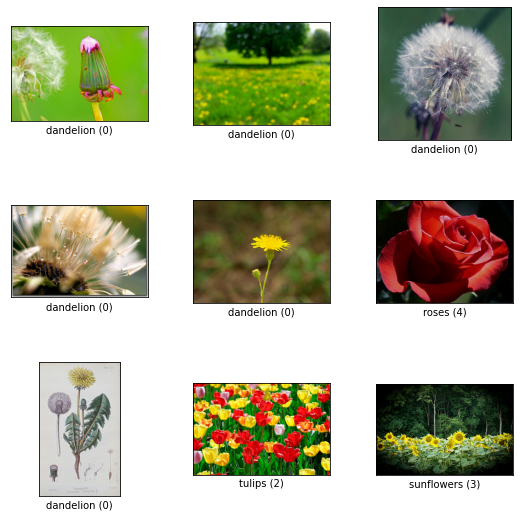

In [50]:
fig = tfds.show_examples(train, info)

In [51]:
for i, example in enumerate(train.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (222, 320, 3) label: 0
Image 2 shape: (240, 320, 3) label: 0
Image 3 shape: (240, 240, 3) label: 0
Image 4 shape: (216, 320, 3) label: 0
Image 5 shape: (240, 320, 3) label: 0


## Build the Input Pipeline

In [52]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

In [74]:
BATCH_SIZE = 184
train_batches = train.shuffle(num_train_img//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = valid.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Create a Feature Vector

In [54]:
mobile_v2 = tf.keras.applications.MobileNetV2
mobile_model = mobile_v2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

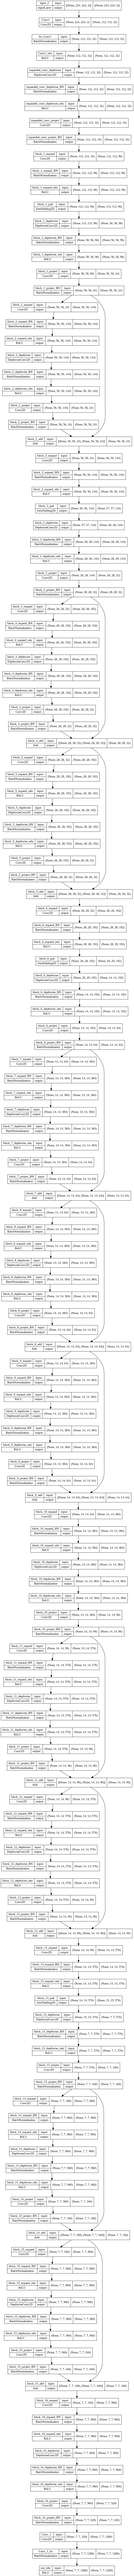

In [55]:
tf.keras.utils.plot_model(
    mobile_model,
    show_shapes=True,
    show_layer_names=True)

In [56]:
len(mobile_model.layers)

154

## Create a Classification Head

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [58]:
for layer in mobile_model.layers:
  layer.trainable = False

In [59]:
xferred_model = tf.keras.Sequential([mobile_model,
                                     GlobalAveragePooling2D(),
                                     Dropout(0.5),
                                     Dense(num_classes, activation='softmax')
                                     ])

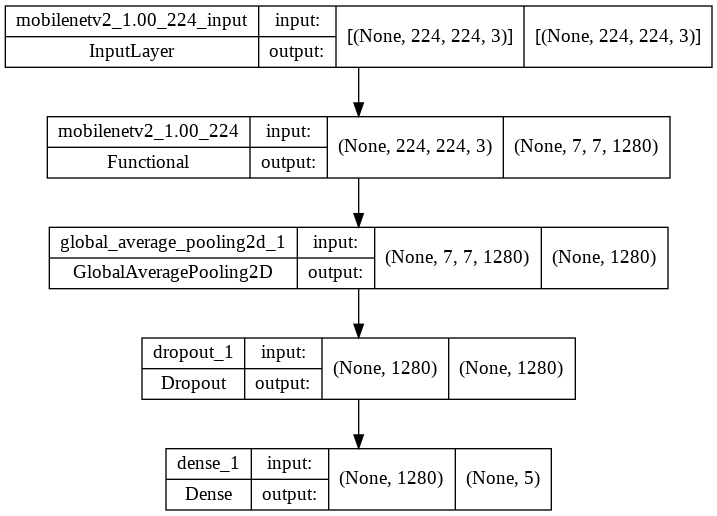

In [60]:
tf.keras.utils.plot_model(xferred_model,
                          show_shapes=True,
                          show_layer_names=True)

## Compile and Train the Model

In [92]:
xferred_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.04),
                      metrics=['accuracy'])

In [93]:
EPOCHS = 20
history = xferred_model.fit(train_batches, epochs=EPOCHS, 
                            validation_data=validation_batches)

Epoch 1/20
18/18 [==============================] - 7s 275ms/step - loss: 0.5611 - accuracy: 0.8834 - val_loss: 0.7553 - val_accuracy: 0.9071
Epoch 2/20
18/18 [==============================] - 4s 238ms/step - loss: 0.5799 - accuracy: 0.8816 - val_loss: 0.6958 - val_accuracy: 0.9235
Epoch 3/20
18/18 [==============================] - 4s 238ms/step - loss: 0.5978 - accuracy: 0.8813 - val_loss: 0.8045 - val_accuracy: 0.9071
Epoch 4/20
18/18 [==============================] - 4s 241ms/step - loss: 0.5549 - accuracy: 0.8919 - val_loss: 0.7581 - val_accuracy: 0.9180
Epoch 5/20
18/18 [==============================] - 4s 241ms/step - loss: 0.5321 - accuracy: 0.8889 - val_loss: 0.8053 - val_accuracy: 0.9180
Epoch 6/20
18/18 [==============================] - 4s 242ms/step - loss: 0.4618 - accuracy: 0.9025 - val_loss: 0.7653 - val_accuracy: 0.9126
Epoch 7/20
18/18 [==============================] - 4s 241ms/step - loss: 0.4590 - accuracy: 0.9064 - val_loss: 0.7572 - val_accuracy: 0.9126
Epoch 

## Visualize Performance

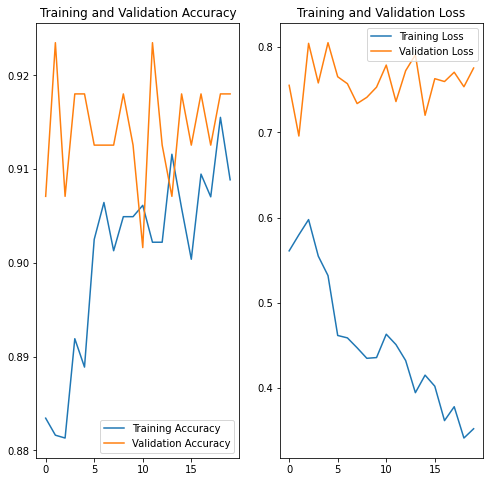

In [94]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Make Predictions from Test Data

In [69]:
predictions = xferred_model.predict(test_batches)

In [70]:
class_labels

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

### Inspect the First Prediction

In [26]:
predictions[0]

array([3.3721251e-35, 2.0484543e-25, 9.9998856e-01, 1.1831437e-22,
       1.1484177e-05], dtype=float32)

In [27]:
predicted_id = np.argmax(predictions[0])
predicted_id

2

In [28]:
class_labels[predicted_id]

'tulips'

In [29]:
for img, lbl in test_batches.take(1):
    print(lbl)

tf.Tensor(
[2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 2 4 2 2 0 0 0 2 0 3 0 1 1 1 2 1 0 0 1 1 0
 3 0 4 4 3 0 4 3 3 2 4 0 1 2 1 3 0 1 4 1 0 2 3 0 0 4 0 1 1 0 1 2 4 3 3 0 3
 2 2 1 0 3 2 0 0 4 3 0 3 3 2 0 2 1 4 0 3 3 3 1 4 0 4 4 4 4 0 4 2 3 4 0 0 4
 4 4 2 2 4 4 3 3 0 3 2 0 1 2 1 4 3 0 2 0 2 2 4 0 3 0 0 1 2 0 1 2 3 1 2 2 0
 3 3 4 0 4 0 4 0 2 2 1 0 2 4 0 0 0 1 1 0 4 1 4 4 3 1 0 1 2 3 4 0 0 3 2 4 1
 0 0 4 4 2 0 3 4 0 0 1 3 2 0 2 2 3 4 0 1 4 1 0 1 2 1 2 2 2 1 0 4 2 4 1 0 0
 4 2 1 0 3 2 1 4 3 1 3 0 0 2 3 4 0 1 2 4 0 3 1 0 1 2 4 0 4 4 2 3 0 4 1 2 2
 4 2 2 3 3 0 0 0 2 4 0 2 2 2 2 0 3 1 4 2 3 3 3 2 0 3 3 4 4 4 4 2 3 3 3], shape=(294,), dtype=int64)


In [30]:
class_labels[lbl[0].numpy()]

'tulips'

### Inspect the First Batch of Predictions

In [71]:
image_batch, label_batch = next(iter(test_batches))
images = image_batch.numpy()
labels = label_batch.numpy()
class_labels[labels[0]]

'tulips'

In [72]:
labels

array([2, 3, 3, 4, 3, 0, 0, 0, 0, 1, 3, 2, 4, 1, 2, 1, 2, 4, 2, 2, 0, 0,
       0, 2, 0, 3, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 3, 0, 4, 4, 3, 0, 4,
       3, 3, 2, 4, 0, 1, 2, 1, 3, 0, 1, 4, 1, 0, 2, 3, 0, 0, 4, 0, 1, 1,
       0, 1, 2, 4, 3, 3, 0, 3, 2, 2, 1, 0, 3, 2, 0, 0, 4, 3, 0, 3, 3, 2,
       0, 2, 1, 4, 0, 3, 3, 3, 1, 4, 0, 4, 4, 4, 4, 0, 4, 2, 3, 4, 0, 0,
       4, 4, 4, 2, 2, 4, 4, 3, 3, 0, 3, 2, 0, 1, 2, 1, 4, 3, 0, 2, 0, 2,
       2, 4, 0, 3, 0, 0, 1, 2, 0, 1, 2, 3, 1, 2, 2, 0, 3, 3, 4, 0, 4, 0,
       4, 0, 2, 2, 1, 0, 2, 4, 0, 0, 0, 1, 1, 0, 4, 1, 4, 4, 3, 1, 0, 1,
       2, 3, 4, 0, 0, 3, 2, 4])

In [75]:
named_labels = [class_labels[labels[i]]
                for i, lbl in enumerate(range(BATCH_SIZE))]
named_labels

['tulips',
 'sunflowers',
 'sunflowers',
 'roses',
 'sunflowers',
 'dandelion',
 'dandelion',
 'dandelion',
 'dandelion',
 'daisy',
 'sunflowers',
 'tulips',
 'roses',
 'daisy',
 'tulips',
 'daisy',
 'tulips',
 'roses',
 'tulips',
 'tulips',
 'dandelion',
 'dandelion',
 'dandelion',
 'tulips',
 'dandelion',
 'sunflowers',
 'dandelion',
 'daisy',
 'daisy',
 'daisy',
 'tulips',
 'daisy',
 'dandelion',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'sunflowers',
 'dandelion',
 'roses',
 'roses',
 'sunflowers',
 'dandelion',
 'roses',
 'sunflowers',
 'sunflowers',
 'tulips',
 'roses',
 'dandelion',
 'daisy',
 'tulips',
 'daisy',
 'sunflowers',
 'dandelion',
 'daisy',
 'roses',
 'daisy',
 'dandelion',
 'tulips',
 'sunflowers',
 'dandelion',
 'dandelion',
 'roses',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'daisy',
 'tulips',
 'roses',
 'sunflowers',
 'sunflowers',
 'dandelion',
 'sunflowers',
 'tulips',
 'tulips',
 'daisy',
 'dandelion',
 'sunflowers',
 'tulips',
 'dandelion',
 'da

In [76]:
predicted_batch = [np.argmax(predictions[i])
                   for i, _ in enumerate(range(BATCH_SIZE))]

In [77]:
named_pred = [class_labels[predicted_batch[i]]
              for i, lbl in enumerate(range(BATCH_SIZE))]
named_pred

['tulips',
 'daisy',
 'sunflowers',
 'roses',
 'sunflowers',
 'dandelion',
 'dandelion',
 'dandelion',
 'dandelion',
 'daisy',
 'sunflowers',
 'tulips',
 'roses',
 'daisy',
 'tulips',
 'daisy',
 'tulips',
 'roses',
 'tulips',
 'tulips',
 'dandelion',
 'dandelion',
 'dandelion',
 'tulips',
 'dandelion',
 'sunflowers',
 'dandelion',
 'daisy',
 'dandelion',
 'daisy',
 'tulips',
 'daisy',
 'dandelion',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'sunflowers',
 'dandelion',
 'roses',
 'dandelion',
 'daisy',
 'dandelion',
 'roses',
 'sunflowers',
 'sunflowers',
 'tulips',
 'roses',
 'dandelion',
 'daisy',
 'tulips',
 'daisy',
 'sunflowers',
 'sunflowers',
 'daisy',
 'roses',
 'daisy',
 'daisy',
 'roses',
 'sunflowers',
 'dandelion',
 'dandelion',
 'roses',
 'dandelion',
 'daisy',
 'daisy',
 'dandelion',
 'daisy',
 'tulips',
 'roses',
 'sunflowers',
 'sunflowers',
 'dandelion',
 'sunflowers',
 'tulips',
 'tulips',
 'daisy',
 'dandelion',
 'sunflowers',
 'tulips',
 'dandelion',
 'dandelio

## Plot Predictions

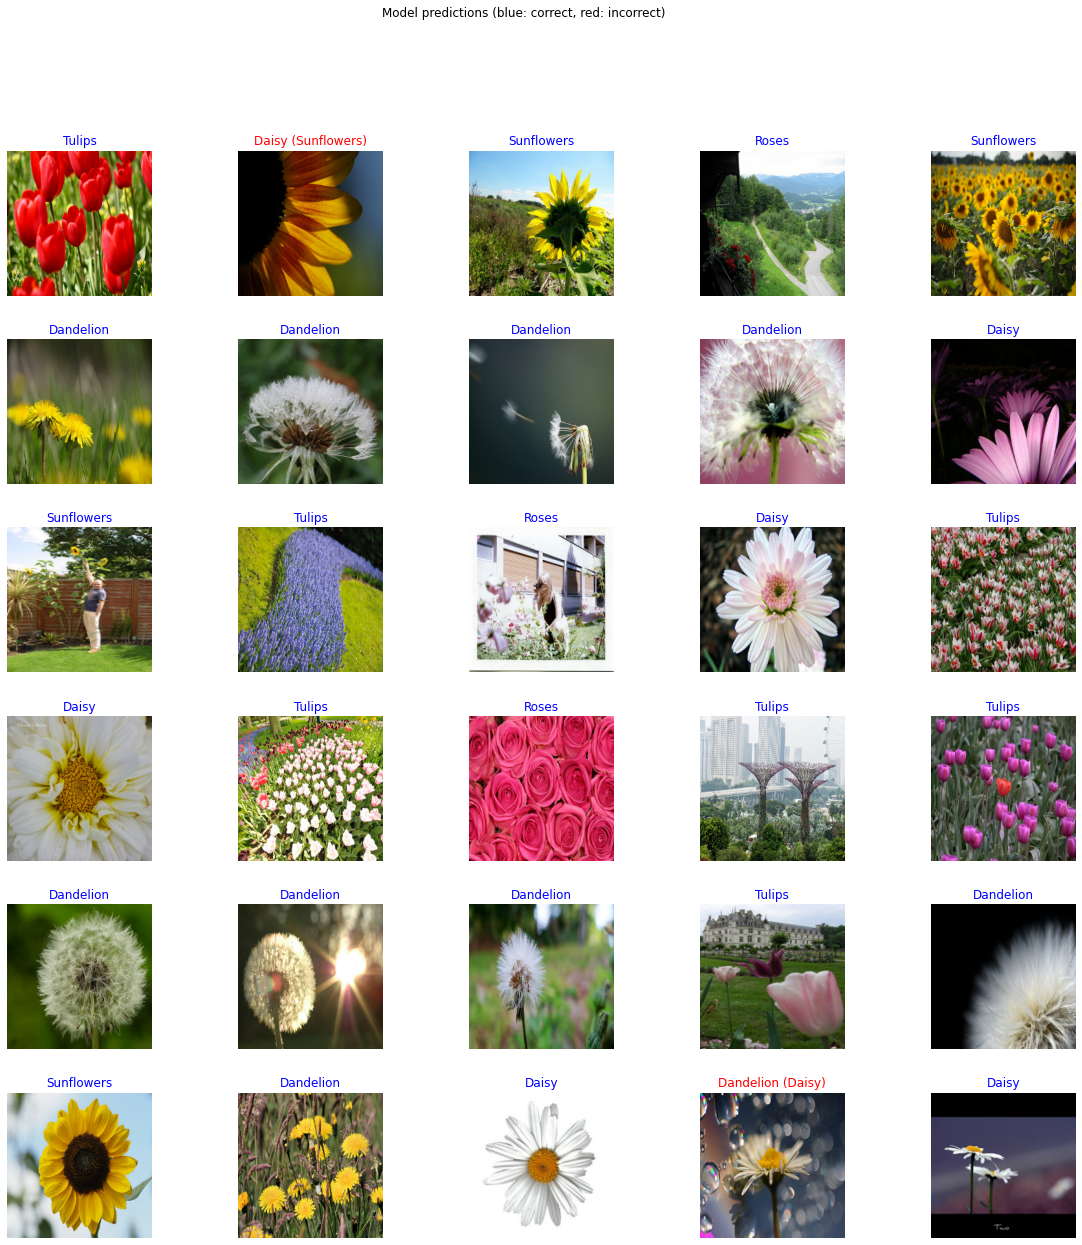

In [78]:
plt.figure(figsize=(20,20))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(images[n])
    color = 'blue' if labels[n] == predicted_batch[n] else 'red'
    if labels[n] != predicted_batch[n]:
        t = named_pred[n].title() + ' (' + named_labels[n].title() + ')'
    else:
        t = named_pred[n].title()
    plt.title(t, color=color)
    plt.axis('off')
    st = 'Model predictions (blue: correct, red: incorrect)'
_ = plt.suptitle(st)